In [1]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np
import os
import pandas_profiling

# Matplotlib and seaborn for visualization
from pandas.tools.plotting import scatter_matrix
import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sb

%matplotlib inline 

# Scipy for statistics
import scipy

# Sklearn for modeling
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, PolynomialFeatures

from sklearn.metrics import accuracy_score, mean_squared_log_error, mean_absolute_error
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from math import sqrt

In [2]:
curDir = os.getcwd()
curDir = 'C:/Users/Reuven/Documents/Python Scripts'
print(curDir)

C:/Users/Reuven/Documents/Python Scripts


# 1. Exploratory Data Analysis

In [3]:
mainDir = curDir + '/StratApp challenge'
trainFile = mainDir + '/train.xlsx'
testFile  = mainDir + '/test.xlsx'

# Read files
origData = pd.read_excel(trainFile)
testData = pd.read_excel(testFile)

# Train Data
origData['Date'] = pd.to_datetime(origData['eDate'])
origData['Weekday'] = origData['Date'].dt.weekday
origData['Dayname'] = origData['Date'].dt.weekday_name
origData['CTR'] = origData['clicks'] / origData['impressions']

# Test Data
testData['Date'] = pd.to_datetime(testData['eDate'])
testData['Weekday'] = testData['Date'].dt.weekday
testData['Dayname'] = testData['Date'].dt.weekday_name

In [4]:
origData.dtypes

impressions                       int64
clicks                            int64
eDate                            object
channel                          object
country                          object
os                               object
networkType                      object
deviceType                       object
publisherCategory                object
advertiserCategory               object
product                         float64
subProduct                       object
campaign                         object
advPackage                       object
advMaturity                      object
AverageWinPrice (CPM)           float64
rate (CPC)                      float64
Date                     datetime64[ns]
Weekday                           int64
Dayname                          object
CTR                             float64
dtype: object

## Data Profiling

In [5]:
# feature profiling on train data
train_prf = pandas_profiling.ProfileReport(origData)
train_prf.to_file(mainDir + '/training_profile_orig.html')

# feature profiling on test data
test_prf = pandas_profiling.ProfileReport(testData)
test_prf.to_file(mainDir + '/testing_profile_orig.html')

In [6]:
#print html profiling
train_prf

Number of variables,21
Number of observations,304629
Total Missing (%),6.3%
Total size in memory,48.8 MiB
Average record size in memory,168.0 B
Numeric,7
Categorical,13
Boolean,0
Date,1
Text (Unique),0
Rejected,0


In [7]:
corr = origData.corr()
sb.set_style(style = 'white')
cmap = sb.diverging_palette(250, 10, as_cmap=True)
#plt.subplots(figsize=(6,4.5))
#sns.heatmap(corr, cmap=cmap, xticklabels=corr.columns, yticklabels=corr.columns)

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '140px', 'font-size': '10pt'})\
    .set_caption("Correlation Matric Orig Data")\
    .set_precision(2)

,impressions,clicks,product,AverageWinPrice (CPM),rate (CPC),Weekday,CTR
impressions,1,0.73,-0.017,-0.0061,-0.0072,-0.0013,-0.0056
clicks,0.73,1,-0.019,0.021,-0.012,-0.00079,0.019
product,-0.017,-0.019,1,-0.014,-0.036,0.025,-0.02
AverageWinPrice (CPM),-0.0061,0.021,-0.014,1,0.44,0.025,0.099
rate (CPC),-0.0072,-0.012,-0.036,0.44,1,0.03,-0.025
Weekday,-0.0013,-0.00079,0.025,0.025,0.03,1,0.0013
CTR,-0.0056,0.019,-0.02,0.099,-0.025,0.0013,1


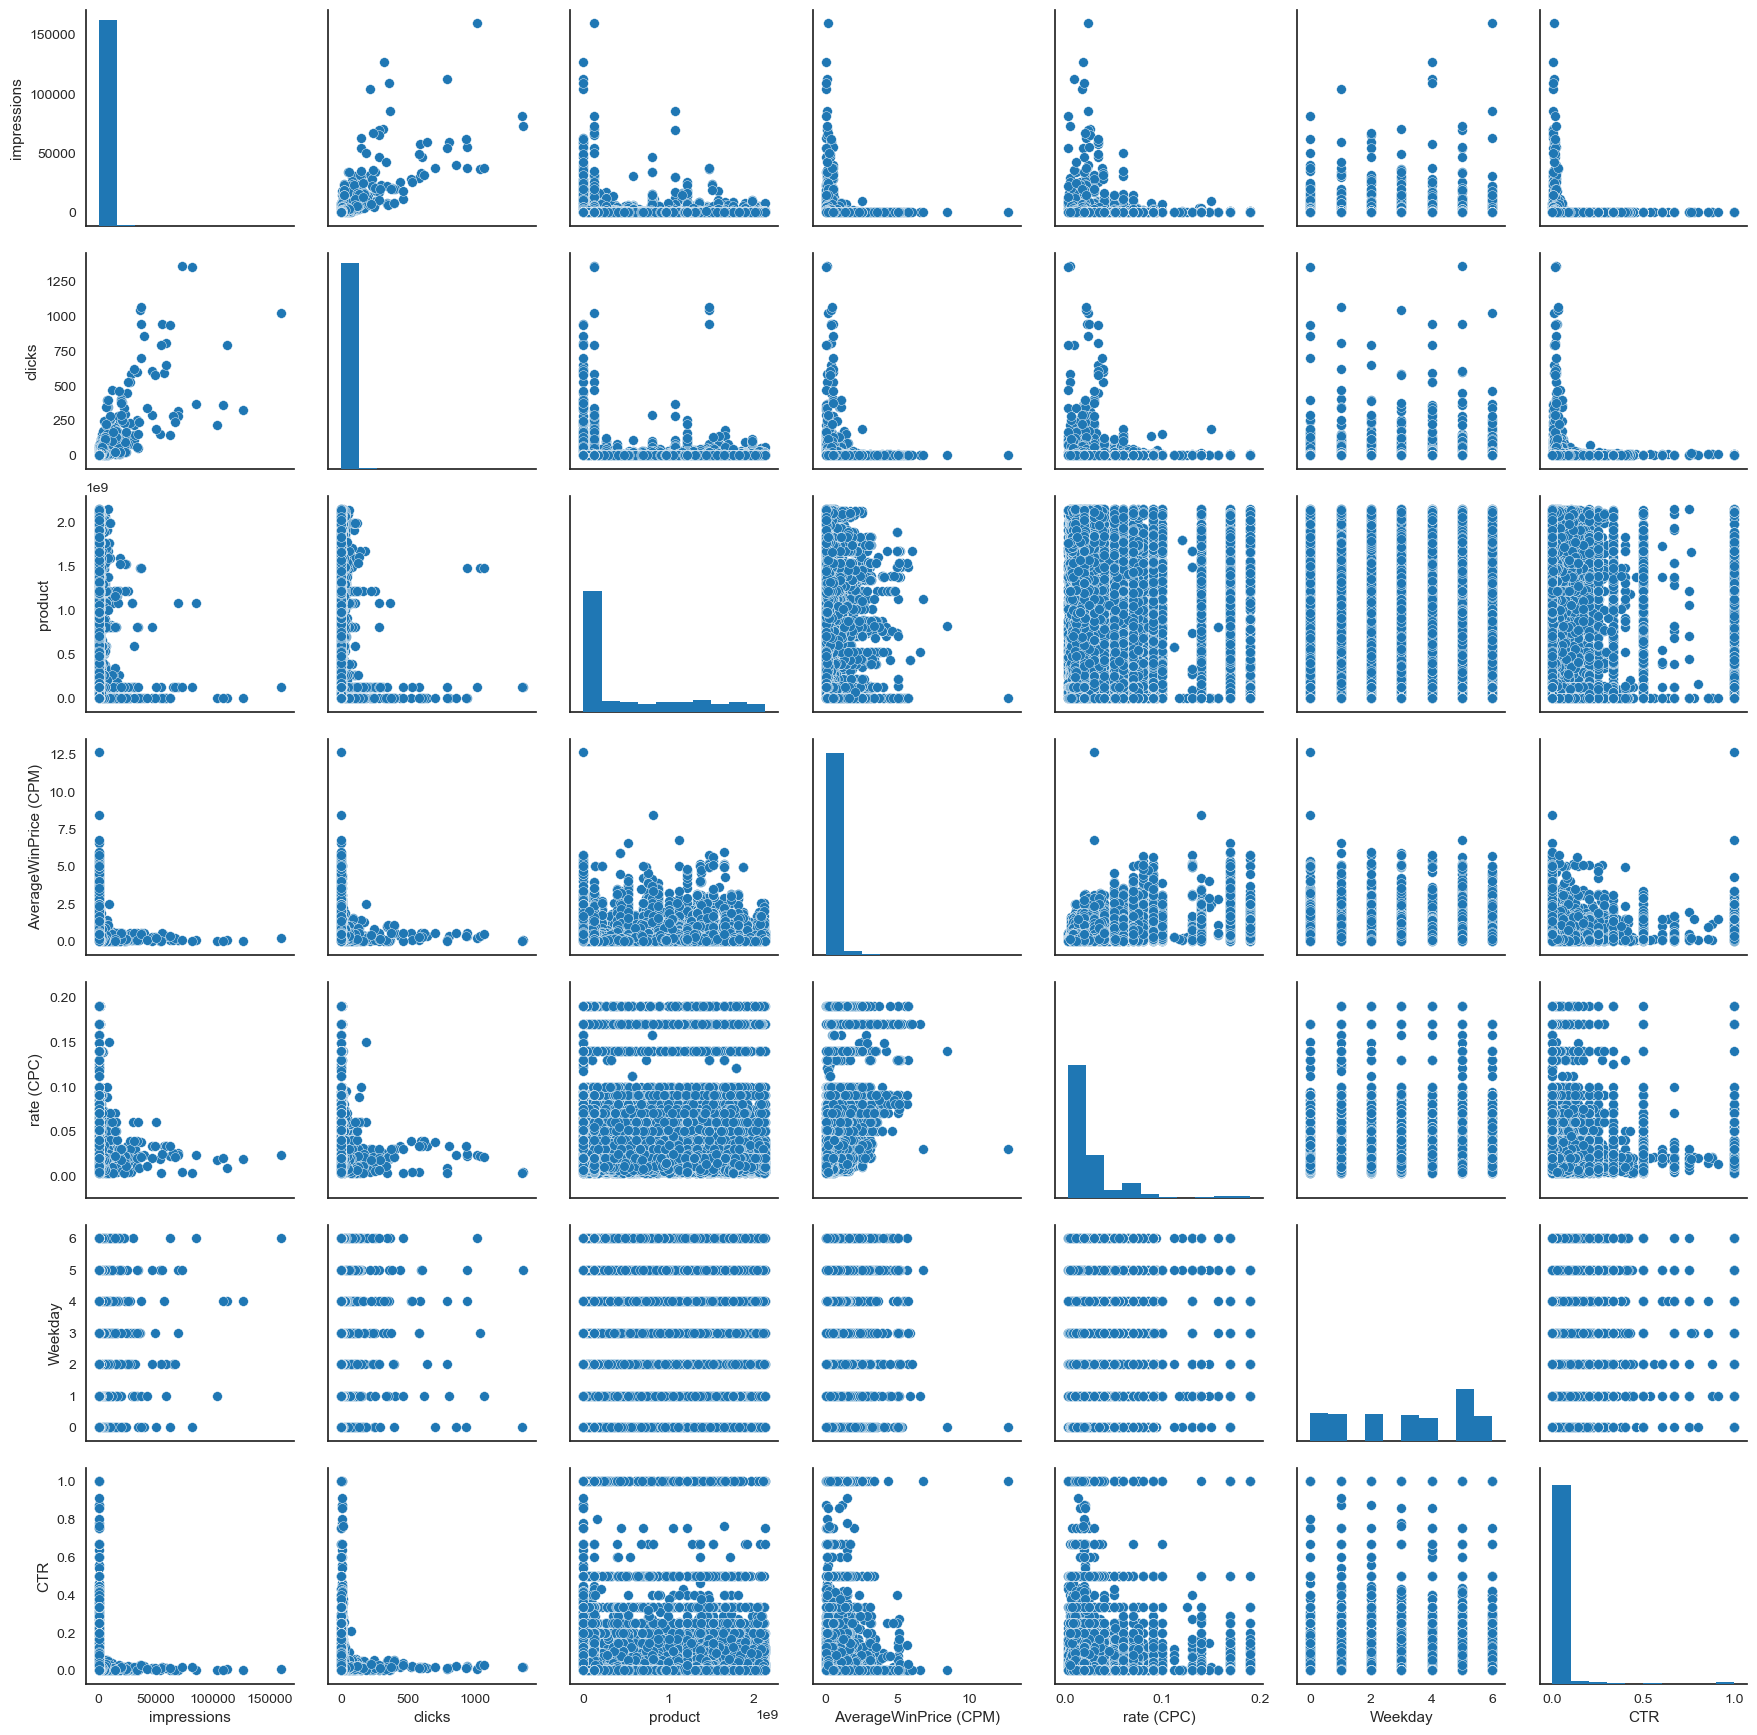

In [8]:
dfTmp = origData.sample(frac=0.5)
dfTmp.fillna(0, inplace=True)
dfTmp.fillna(0, inplace=True)
sb.pairplot(dfTmp)

# 2. Feature Engineering

In [9]:
test_features = ['channel', 'country', 'os', 'networkType', 'deviceType', 'publisherCategory',
                 'advertiserCategory', 'product', 'subProduct', 'campaign', 'advPackage', 'advMaturity']

base_features = ['channel', 'country', 'os', 'networkType', 'deviceType', 'publisherCategory',
                 'advertiserCategory', 'product', 'subProduct', 'campaign', 'advPackage', 'advMaturity',
                 'AverageWinPrice (CPM)', 'rate (CPC)', 'Weekday', 'Dayname']

# Test the Date feature:
# using Date will eliminate duplicates; using Weekday will eliminate less
num_dup = (origData.duplicated(subset=['channel', 'country', 'os', 'networkType', 'deviceType', 'publisherCategory',
                                       'advertiserCategory', 'product', 'subProduct', 'campaign', 'advPackage',
                                       'advMaturity', 'Date']) == True).sum()
print("Num of Duplicates (with 'Date'): {}".format(num_dup))
num_dup = (origData.duplicated(subset=['channel', 'country', 'os', 'networkType', 'deviceType', 'publisherCategory',
                                       'advertiserCategory', 'product', 'subProduct', 'campaign', 'advPackage',
                                       'advMaturity', 'Weekday']) == True).sum()
print("Num of Duplicates (with 'Weekday'): {}".format(num_dup))

origData.columns

Num of Duplicates (with 'Date'): 0
Num of Duplicates (with 'Weekday'): 14586


Index(['impressions', 'clicks', 'eDate', 'channel', 'country', 'os',
       'networkType', 'deviceType', 'publisherCategory', 'advertiserCategory',
       'product', 'subProduct', 'campaign', 'advPackage', 'advMaturity',
       'AverageWinPrice (CPM)', 'rate (CPC)', 'Date', 'Weekday', 'Dayname',
       'CTR'],
      dtype='object')

### Missing Values

In [10]:
origData.isnull().sum()

impressions                   0
clicks                        0
eDate                         0
channel                       0
country                      11
os                            0
networkType                   0
deviceType                    0
publisherCategory         50734
advertiserCategory         4721
product                   64599
subProduct                52806
campaign                   1678
advPackage               228241
advMaturity                   1
AverageWinPrice (CPM)         0
rate (CPC)                    0
Date                          0
Weekday                       0
Dayname                       0
CTR                           0
dtype: int64

In [11]:
origData.fillna('unknown', inplace=True)
origData.fillna('unknown', inplace=True)

### Experiment Aggregated Data (e.g. excluding 'Date' and/or other Columns)

In [12]:
# lambda function to compute the weighted CPC mean:
cpc_mean = lambda x: 0 if sum(origData.loc[x.index, 'clicks']) == 0 else np.average(origData.loc[x.index, 'rate (CPC)'], weights=origData.loc[x.index, 'clicks'])

ALL_columns = ['channel', 'country', 'os', 'networkType', 'deviceType', 'publisherCategory',
               'advertiserCategory', 'product', 'subProduct', 'campaign', 'advPackage', 'advMaturity',
               'Weekday']

AGG_columns = ['channel', 'country', 'os', 'networkType', 'deviceType', 'publisherCategory',
               'advertiserCategory', 'product', 'subProduct', 'campaign', 'advPackage', 'advMaturity',
               'Weekday']

###### FOR TESTING ######
#AGG_columns = ALL_columns

aggregations = {
    'rate (CPC)': 'mean', #cpc_mean,
    'Date': 'count',
    'impressions': 'sum',
    'clicks': 'sum',
}
trainAgg = origData.groupby(AGG_columns, as_index=False).agg(aggregations)
trainAgg.rename(columns={'rate (CPC)': "avgCPC"}, inplace=True)

print("Total Records after Aggregation:\n{}:".format(trainAgg.count()))

####################
is_AGG = True
if is_AGG:
    print("INFO: Using Aggregation mode!!!")
trainData = trainAgg
####################

Total Records after Aggregation:
channel               290043
country               290043
os                    290043
networkType           290043
deviceType            290043
publisherCategory     290043
advertiserCategory    290043
product               290043
subProduct            290043
campaign              290043
advPackage            290043
advMaturity           290043
Weekday               290043
avgCPC                290043
Date                  290043
impressions           290043
clicks                290043
dtype: int64:
INFO: Using Aggregation mode!!!


### Explore Dependent Variable/Response

In [13]:
trainData.head(10)

,channel,country,os,networkType,deviceType,publisherCategory,advertiserCategory,product,subProduct,campaign,advPackage,advMaturity,Weekday,avgCPC,Date,impressions,clicks
0,inr,AE,android,3g,mobile,books & reference,entertainment,630535,unknown,301102110,unknown,low maturity,0,0.0170,1,53,0
1,inr,AE,android,3g,mobile,books & reference,entertainment,630535,unknown,301102110,unknown,low maturity,1,0.0170,1,7,0
2,inr,AE,android,3g,mobile,dating,entertainment,607044,com.jnj.mocospace.android,301102110,unknown,low maturity,0,0.0170,1,47,0
3,inr,AE,android,3g,mobile,dating,entertainment,607044,com.jnj.mocospace.android,301102110,unknown,low maturity,1,0.0170,1,78,1
4,inr,AE,android,3g,mobile,dating,entertainment,607044,com.jnj.mocospace.android,301102110,unknown,low maturity,2,0.0170,1,13,0
5,inr,AE,android,3g,mobile,dating,entertainment,607044,com.jnj.mocospace.android,301102110,unknown,low maturity,3,0.0170,1,19,0
6,inr,AE,android,3g,mobile,dating,entertainment,607044,com.jnj.mocospace.android,301102110,unknown,low maturity,4,0.0170,1,6,0
7,inr,AE,android,3g,mobile,dating,entertainment,607044,com.jnj.mocospace.android,301102110,unknown,low maturity,5,0.0185,2,142,0
8,inr,AE,android,3g,mobile,dating,entertainment,607044,com.jnj.mocospace.android,301102264,unknown,low maturity,1,0.0150,1,7,0
9,inr,AE,android,3g,mobile,dating,entertainment,607044,com.jnj.mocospace.android,301102264,unknown,low maturity,2,0.0150,1,1,0


In [14]:
# use posterior with conjugate Beta for predicted variable

beta_mean = lambda a,b : a/(a+b)

trainData['CTR'] = trainData['clicks'] / trainData['impressions']
trainData['betabCTR'] = trainData.apply(lambda row: beta_mean(1 + row['clicks'], 1 + row['impressions']-row['clicks']), axis=1)
trainData['logitCTR'] = trainData.apply(lambda row: np.log(row['betabCTR']/(1-row['betabCTR'])), axis=1)

avgCTR = trainData['clicks'].sum()/trainData['impressions'].sum()
print("Baseline CTR: {}".format(avgCTR))
trainData['resCTR'] = np.where(trainData['clicks'] > 0,
                               (1-avgCTR)*trainData['clicks']/trainData['impressions'],
                               avgCTR/trainData['impressions']) 
trainData['logresCTR'] = trainData.apply(lambda row: np.log(row['resCTR']/(1-row['resCTR'])), axis=1)

Baseline CTR: 0.008626930665641764


In [15]:
logit2prob = lambda logit: np.exp(logit) / (1 + np.exp(logit))
logit2prob(-4.5)

0.01098694263059318

Text(0.5,0,'logresCTR')

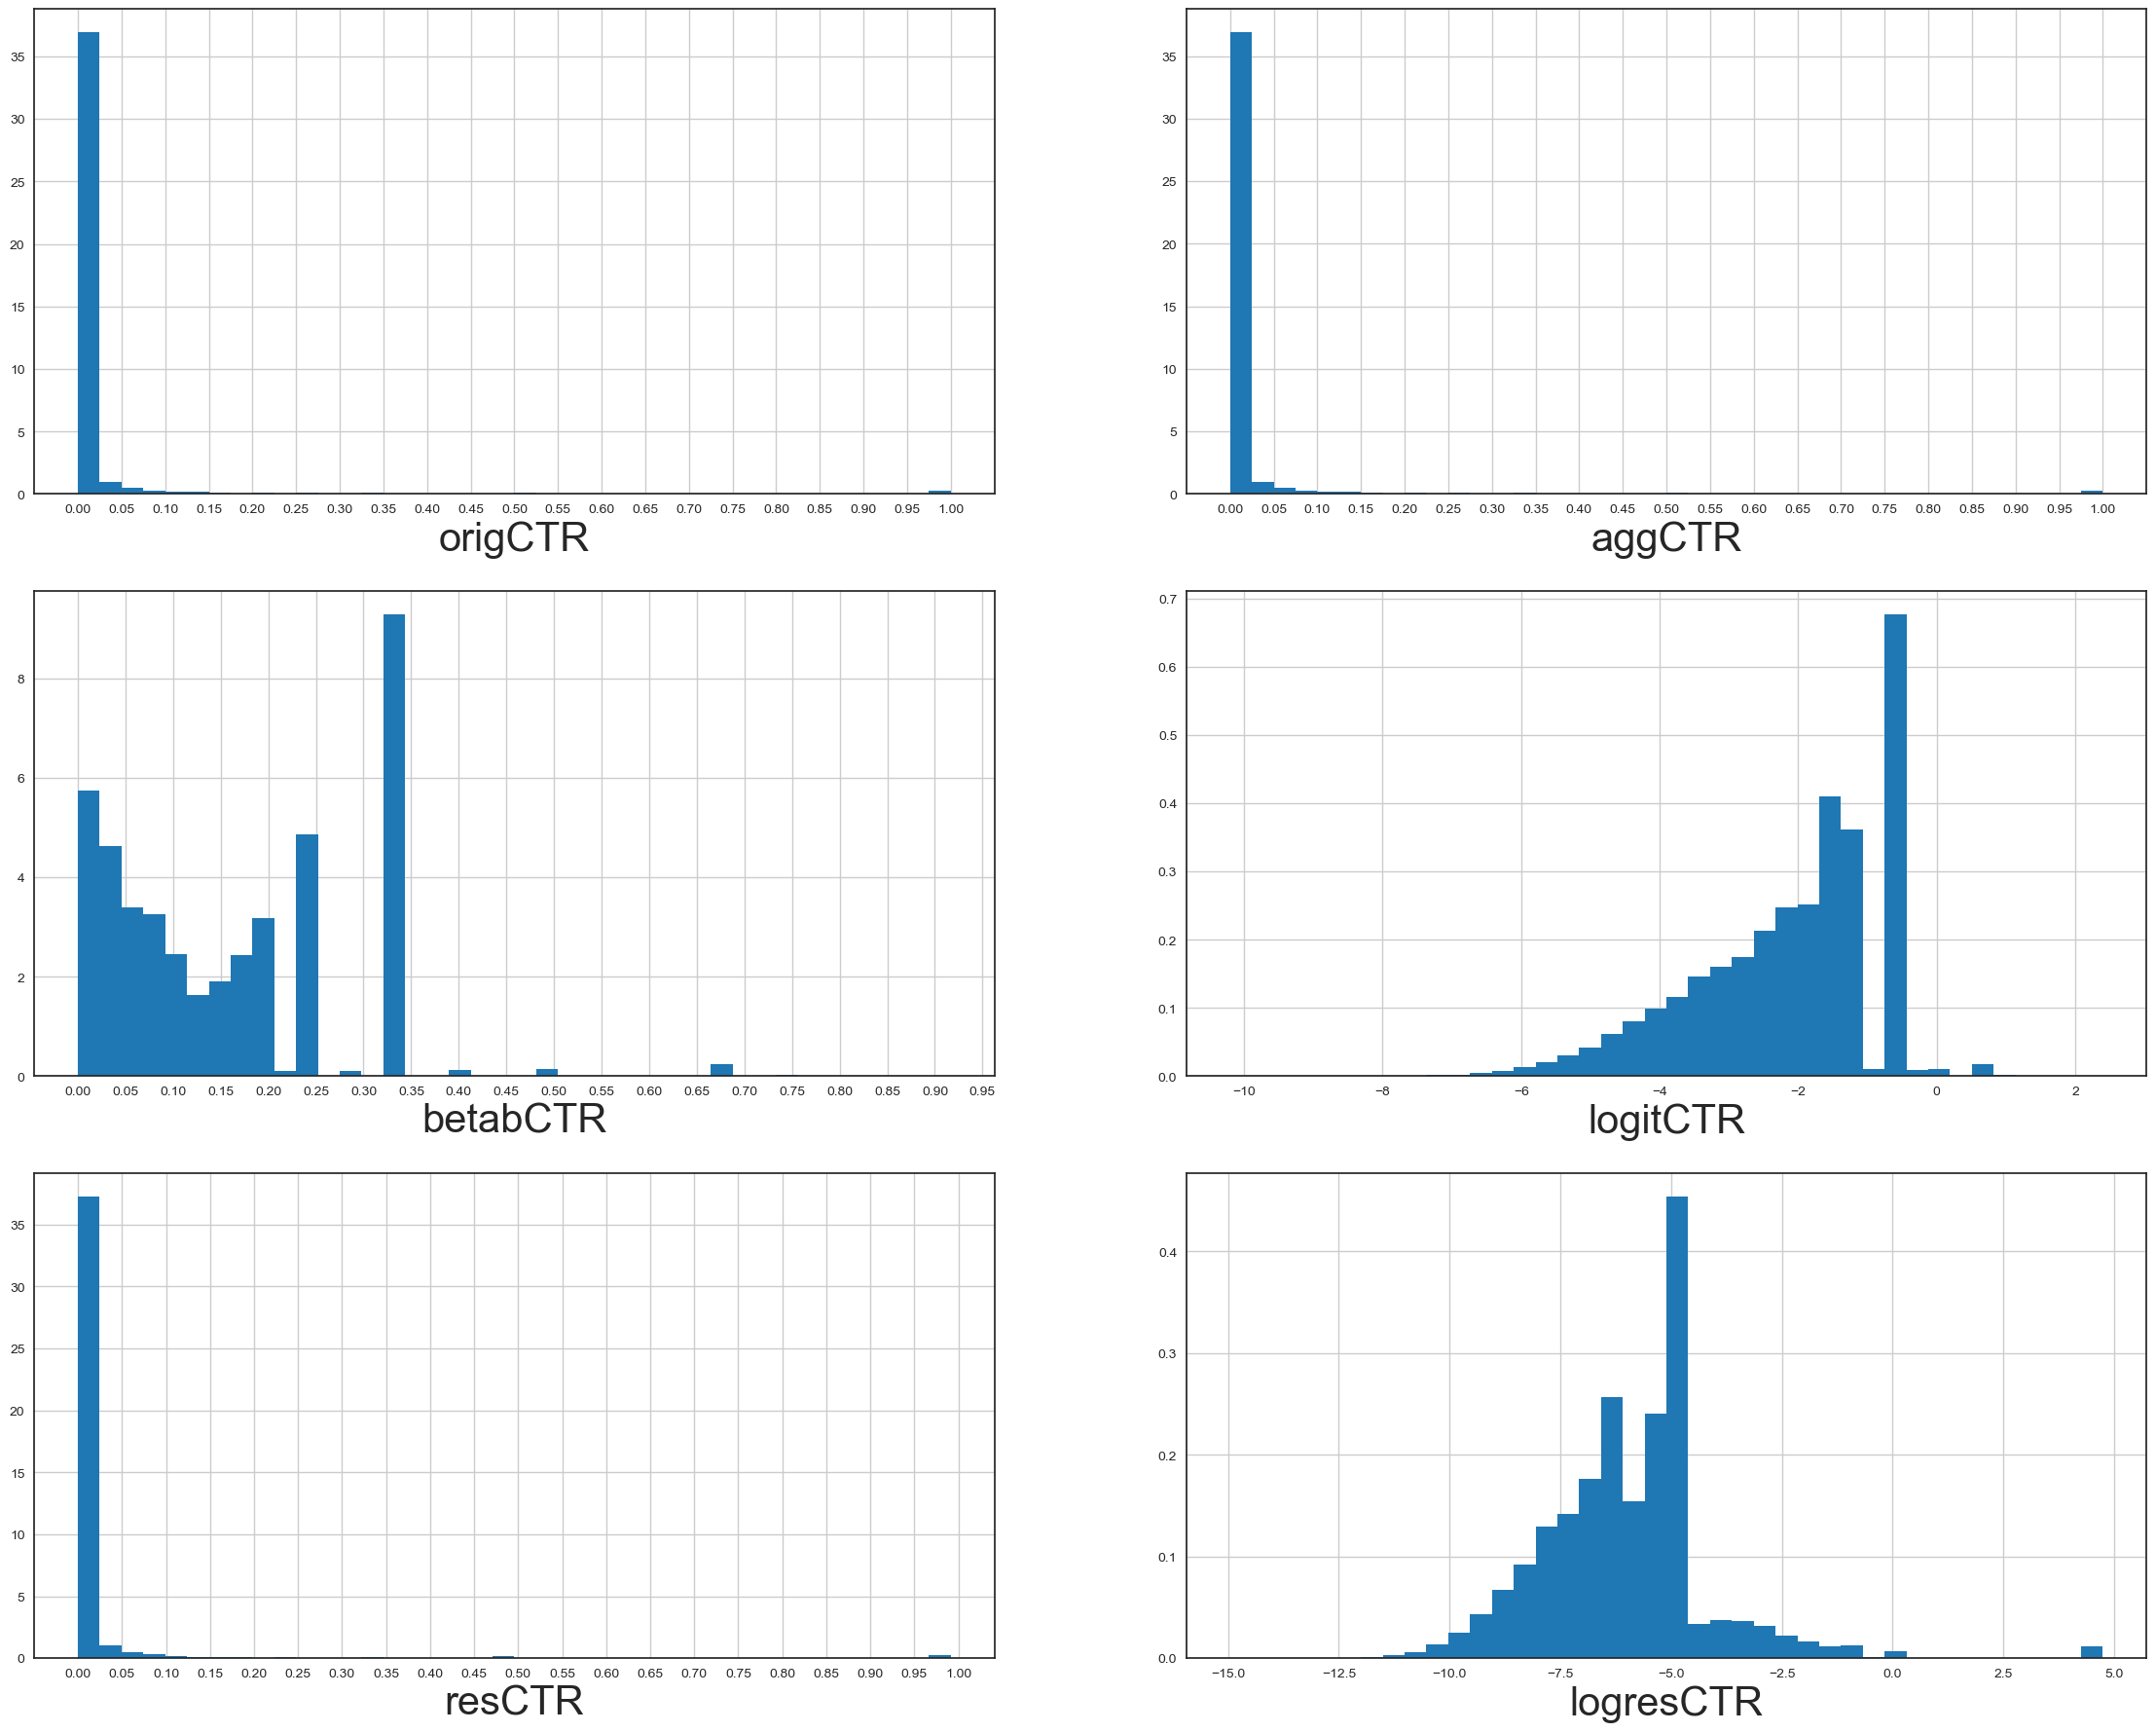

In [16]:
plt.figure(1)
plt.figure(figsize=(28,22))

x1 = origData['CTR'].values
plt.subplot(321)
plt.grid(True)
xticks = np.arange(0, 1.05, 0.05)
plt.xticks(xticks)
plt.xlabel('origCTR', size=30)
plt.hist(x1, normed=True, bins=40)

x2 = trainData['CTR'].values
plt.subplot(322)
plt.grid(True)
xticks = np.arange(0, 1.05, 0.05)
plt.xticks(xticks)
plt.xlabel('aggCTR', size=30)
plt.hist(x2, normed=True, bins=40)

x3 = trainData['betabCTR'].values
plt.subplot(323)
plt.grid(True)
xticks = np.arange(0, 1.05, 0.05)
plt.xticks(xticks)
plt.xlabel('betabCTR', size=30)
plt.hist(x3, normed=True, bins=40)

x4 = trainData['logitCTR'].values
plt.subplot(324)
plt.grid(True)
plt.hist(x4, normed=True, bins=40)
plt.xlabel('logitCTR', size=30)

x5 = trainData['resCTR'].values
plt.subplot(325)
plt.grid(True)
xticks = np.arange(0, 1.05, 0.05)
plt.xticks(xticks)
plt.hist(x5, normed=True, bins=40)
plt.xlabel('resCTR', size=30)

x6 = trainData['logresCTR'].values
plt.subplot(326)
plt.grid(True)
plt.hist(x6, normed=True, bins=40)
plt.xlabel('logresCTR', size=30)

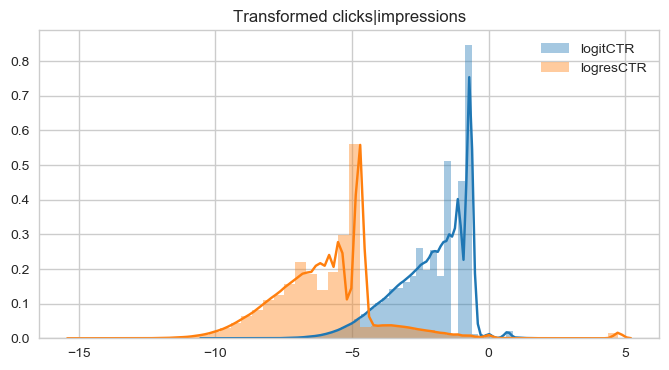

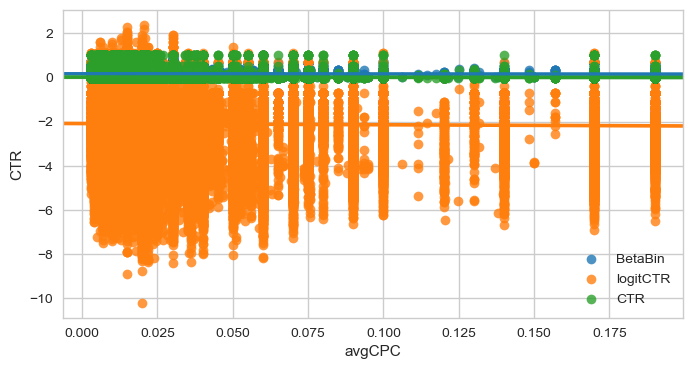

In [61]:
# scatterplot for avgCPC and CTR
rcParams['figure.figsize'] = 8, 4
sb.set_style('whitegrid')

plt.title('Transformed clicks|impressions')
sb.distplot(trainData['logitCTR'],  label='logitCTR')
sb.distplot(trainData['logresCTR'], label='logresCTR')
plt.xlabel('') 
plt.legend()
plt.show()

sb.regplot(x='avgCPC', y='betabCTR', label='BetaBin', data=trainData, scatter=True)
sb.regplot(x='avgCPC', y='logitCTR', label='logitCTR', data=trainData, scatter=True)
sb.regplot(x='avgCPC', y='CTR', label='CTR', data=trainData, scatter=True)
plt.legend(loc='lower right')
plt.show()

### Baseline model CTR

In [18]:
# Compute score/variance for base model by avgCTR for clicks/impressions
print("Baseline Avg CTR: {}".format(avgCTR))
y_t = trainData['CTR']
y_p = [avgCTR] * len(y_t)
print('R^2: {} / Explained Var: {} / MSE: {} / RMSE {}'.format
      (round(r2_score(y_t, y_p),4),
       round(explained_variance_score(y_t, y_p),4),
       round(mean_squared_error(y_t, y_p),4),
       round(sqrt(mean_squared_error(y_t, y_p)),4)))

aggregations = {'channel': 'count', 'impressions': 'sum', 'clicks': 'sum'}

# Weekend seems more activity; Sunday seems higher CTR; maybe beacuse people do it quickly...
grpCTR = lambda row: row['clicks'].sum()/row['impressions'].sum()
grps = trainData.groupby(['publisherCategory', 'advertiserCategory'], as_index=False).agg(aggregations)
grps['CTR%'] = grps['clicks']/grps['impressions']
(grps.sort_values('CTR%', ascending=False)).head(10)

Baseline Avg CTR: 0.008626930665641764
R^2: -0.0056 / Explained Var: 0.0 / MSE: 0.008 / RMSE 0.0894


,publisherCategory,advertiserCategory,channel,impressions,clicks,CTR%
206,entertainment,social networking,1,1,1,1.000000
399,game_casual,events,1,1,1,1.000000
386,game_casino,lifestyle,2,5,3,0.600000
600,game_sports,events,2,2,1,0.500000
693,games,utilities,2,2,1,0.500000
326,game_board,events,2,7,2,0.285714
770,lifestyle,social,4,4,1,0.250000
391,game_casino,travel & local,17,150,36,0.240000
487,game_puzzle,events,4,9,2,0.222222
444,game_educational,lifestyle,1,5,1,0.200000


### Feature Encoding and Sacling

In [19]:
# TODO's:
# 1. Maybe use feature hashing for 'product' and 'subProduct', and 'campaign'?
# 2. Campaign seems superset for some attributes
# 3. Drop date as it has only 8 distinct values (1 week) and no timestamp
# 4. Plot regression lines for each feature with the CTR
# 5. ???ploy2 features to capture inter-relations between Publisher-Advertiser
# 6. Check if new feature data is introduced in the test data
# 7. Feature Hashing: to avoid new test data with no matching feature in training model?

"""
•CTR has 261664 / 85.9% zeros Zeros
•Weekday has 40739 / 13.4% zeros Zeros
•advPackage has 228241 / 74.9% missing values Missing
•advPackage has a high cardinality: 66 distinct values Warning
•advertiserCategory has 4721 / 1.5% missing values Missing
•campaign has a high cardinality: 371 distinct values Warning
•clicks has 261664 / 85.9% zeros Zeros
•clicks is highly skewed (γ1 = 62.852) Skewed
•country has a high cardinality: 54 distinct values Warning
•impressions is highly skewed (γ1 = 55.867) Skewed
•product has 64599 / 21.2% missing values Missing
•publisherCategory has 50734 / 16.7% missing values Missing
•subProduct has 52806 / 17.3% missing values Missing
•subProduct has a high cardinality: 876 distinct values Warning
"""

# take out 'advPackage': missiing values, 'product', 'subProduct': high cardinality
COLS_111 = ['channel', 'country', 'os', 'networkType', 'deviceType', 'publisherCategory',
            'advertiserCategory', 'campaign', 'advMaturity',
            'avgCPC']


# LE without OH for Random Forests only
RFR_columns = ['channel', 'country', 'os', 'networkType', 'deviceType', 'publisherCategory',
               'advertiserCategory', 'product', 'subProduct', 'campaign', 'advPackage', 'advMaturity',
               'Weekday', 'avgCPC']

# One-Hot with Reduced dimensionality
REG_columns = ['channel', 'country', 'networkType', 'deviceType', 'publisherCategory',
               'advertiserCategory', 'product', 'campaign', 'advMaturity',
               'avgCPC']

pd.set_option('display.max_columns', 2000)

## Label Encoding

In [20]:
from sklearn.model_selection import train_test_split
from scipy.stats import beta
from scipy.special import logit

CAT_columns = ['channel', 'country', 'os', 'networkType', 'deviceType', 'publisherCategory',
               'advertiserCategory', 'product', 'subProduct', 'campaign', 'advPackage', 'advMaturity']

# Label Encoder for categorical features
dfLE   = trainData.copy()
dfTest = testData.copy()
dfMerged  = pd.concat([dfLE, dfTest])

le_dict = {col: LabelEncoder() for col in CAT_columns }

for col in CAT_columns:
    print("LabelEncoder: {} / type: {}".format(col, dfMerged[col].dtypes))
    dfMerged[col] = le_dict[col].fit_transform(dfMerged[col].astype('str'))
    dfLE[col]     = le_dict[col].transform(dfLE[col].astype('str'))
    dfTest[col]   = le_dict[col].transform(dfTest[col].astype('str'))
    
if not is_AGG:
    print("INFO: Using Sampling for partial train data")
    dfLE = dfLE.sample(frac=0.2, random_state=1)
dfLE.head()

LabelEncoder: channel / type: object
LabelEncoder: country / type: object
LabelEncoder: os / type: object
LabelEncoder: networkType / type: object
LabelEncoder: deviceType / type: object
LabelEncoder: publisherCategory / type: object
LabelEncoder: advertiserCategory / type: object
LabelEncoder: product / type: object
LabelEncoder: subProduct / type: object
LabelEncoder: campaign / type: object
LabelEncoder: advPackage / type: object
LabelEncoder: advMaturity / type: object


,channel,country,os,networkType,deviceType,publisherCategory,advertiserCategory,product,subProduct,campaign,advPackage,advMaturity,Weekday,avgCPC,Date,impressions,clicks,CTR,betabCTR,logitCTR,resCTR,logresCTR
0,0,0,0,0,0,2,6,1867,1243,291,68,7,0,0.017,1,53,0,0.000000,0.018182,-3.988984,0.000163,-8.722996
1,0,0,0,0,0,2,6,1867,1243,291,68,7,1,0.017,1,7,0,0.000000,0.111111,-2.079442,0.001232,-6.697543
2,0,0,0,0,0,6,6,1672,595,291,68,7,0,0.017,1,47,0,0.000000,0.020408,-3.871201,0.000184,-8.602831
3,0,0,0,0,0,6,6,1672,595,291,68,7,1,0.017,1,78,1,0.012821,0.025000,-3.663562,0.012710,-4.352582
4,0,0,0,0,0,6,6,1672,595,291,68,7,2,0.017,1,13,0,0.000000,0.066667,-2.639057,0.000664,-7.317152


### One-Hot Encoding

In [21]:
# One-Hot encoding categorical features into dummy variables
dfOHE = trainData
dfOHE = pd.get_dummies(dfOHE, columns=AGG_columns)
if not is_AGG:
    print("INFO: Using Sampling for partial train data")
    dfOHE = dfOHE.sample(frac=0.2, random_state=1)

In [22]:
dfOHE.head()

avgCPC  Date  impressions  clicks       CTR  betabCTR  logitCTR    resCTR  \
0   0.017     1           53       0  0.000000  0.018182 -3.988984  0.000163   
1   0.017     1            7       0  0.000000  0.111111 -2.079442  0.001232   
2   0.017     1           47       0  0.000000  0.020408 -3.871201  0.000184   
3   0.017     1           78       1  0.012821  0.025000 -3.663562  0.012710   
4   0.017     1           13       0  0.000000  0.066667 -2.639057  0.000664   

   logresCTR  channel_inr  channel_mpb  channel_nxg  channel_rub  channel_smt  \
0  -8.722996            1            0            0            0            0   
1  -6.697543            1            0            0            0            0   
2  -8.602831            1            0            0            0            0   
3  -4.352582            1            0            0            0            0   
4  -7.317152            1            0            0            0            0   

   country_AE  country_AT  country_AU  country_BH  country_BR  country_CA  \
0           1           0           0           0           0           0   
1           1           0           0           0           0           0   
2           1           0           0           0           0           0   
3           1           0           0           0           0           0   
4           1           0           0           0           0           0   

   country_CI  country_CL  country_CR  country_DE  country_DO  country_DZ  \
0           0           0           0           0           0           0   
1           0           0           0           0           0           0   
2           0           0           0           0           0           0   
3           0           0           0           0           0           0   
4           0           0           0           0           0           0   

   country_EG  country_ES  country_FR  country_GB  country_HK  country_HN  \
0           0           0           0           0           0           0   
1           0           0           0           0           0           0   
2           0           0           0           0           0           0   
3           0           0           0           0           0           0   
4           0           0           0           0           0           0   

   country_HU  country_ID  country_IN  country_IT  country_JP  country_KH  \
0           0           0           0           0           0           0   
1           0           0           0           0           0           0   
2           0           0           0           0           0           0   
3           0           0           0           0           0           0   
4           0           0           0           0           0           0   

   country_KR  country_KW  country_MA  country_MM  country_MX  country_MY  \
0           0           0           0           0           0           0   
1           0           0           0           0           0           0   
2           0           0           0           0           0           0   
3           0           0           0           0           0           0   
4           0           0           0           0           0           0   

   country_NG  country_NL  country_NO  country_OM  country_PA  country_PH  \
0           0           0           0           0           0           0   
1           0           0           0           0           0           0   
2           0           0           0           0           0           0   
3           0           0           0           0           0           0   
4           0           0           0           0           0           0   

   country_PK  country_PL  country_PT  country_PY  country_QA  country_RS  \
0           0           0           0           0           0           0   
1           0           0           0           0           0           0   
2           0           0 

In [23]:
print("Total Varibales including dummies: {}".format(len(dfOHE.columns)))
OHE_columns = [col for col in dfOHE.columns if col not in {'resCTR', 'logresCTR', 'avgCPC', 'Date','impressions','clicks','CTR','betabCTR','logitCTR'}]
print("Total Varibales including dummies: {}".format(len(OHE_columns)))

Total Varibales including dummies: 2601
Total Varibales including dummies: 2592


### Helper Functions

In [24]:
def print_model_scores(y_test, y_pred):
    if (y_test < 0).any() or (y_pred < 0).any():
        print('R^2: {} / Explained Var: {} / MSE: {} / RMSE {}'.format
              (round(r2_score(y_test, y_pred),4),
               round(explained_variance_score(y_test, y_pred),4),
               round(mean_squared_error(y_test, y_pred),4),
               round(sqrt(mean_squared_error(y_test, y_pred)),4)))
    else:
        print('R^2: {} / Explained Var: {} / MSE: {} / RMSE {} / MSLE: {}'.format
              (round(r2_score(y_test, y_pred),4),
               round(explained_variance_score(y_test, y_pred),4),
               round(mean_squared_error(y_test, y_pred),4),
               round(sqrt(mean_squared_error(y_test, y_pred)),4),
               round(mean_squared_log_error(y_test, y_pred),4)))

        
def print_lreg_scores(reg_name, reg_type, dependent,
                      X_train, y_train, y_train_pred,
                      X_valid, y_valid, y_valid_pred):
    # print coefs and statistics
    print("\n>>>>>>>>>>>> Model: {} / Dependent: {}:\n".format(reg_name, dependent))
    print("Regression Model: %s\n"            % reg_type)
    
    print("Training Model Score/R^2: %.4f"    % reg_type.score(X_train, y_train))
    print("Training Variance/R^2: %.4f"       % r2_score(y_train, y_train_pred))
    print("Training MSE: %.4f\n"              % mean_squared_error(y_train, y_train_pred))
    
    print("Validation Model Score/R^2: %.4f"  % reg_type.score(X_valid, y_valid))
    print("Validation Variance/R^2: %.4f"     % r2_score(y_valid, y_valid_pred))
    print("Validation MSE: %.4f\n"            % mean_squared_error(y_valid, y_valid_pred))
    
    pd.DataFrame(data=reg_type.coef_.reshape(1,-1), index=[reg_name], columns=X_train.columns)
    print("Coefficients:\n", reg_type.coef_)
    print("Intercept: %.4f\n" % reg_type.intercept_)

# 3. Linear Regression

In [26]:
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge

In [ ]:
### LASSO
dependent = 'logitCTR'
dfOHE = dfOHE.sample(frac=0.6, random_state=1)
X_data = dfOHE[OHE_columns]
y_data = dfOHE[dependent]

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2)

lasso_model = Lasso(alpha=0.5, normalize=False)
lasso_model.fit(X_train, y_train)

In [ ]:
y_train_pred = lasso_model.predict(X_train)
y_test_pred = lasso_model.predict(X_test)
print_lreg_scores('LASSO', lasso_model, dependent, X_train, y_train, y_train_pred, X_test, y_test, y_test_pred)

In [ ]:
print("Lasso Train Score: {}:".format(lasso_model.score(X_train, y_train)))
print("Lasso Test Score : {}:".format(lasso_model.score(X_test, y_test)))
print("\nCoef:\n", pd.Series(lasso_model.coef_, X_train.columns).sort_values(ascending=False))

In [ ]:
### RIDGE
dependent = 'logitCTR'
dfOHE = dfOHE.sample(frac=0.6, random_state=1)
X_data = dfOHE[OHE_columns]
y_data = dfOHE[dependent]

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2)

ridge_model = Ridge(alpha=0.05, normalize=False)
ridge_model.fit(X_train, y_train)

In [ ]:
y_train_pred = ridge_model.predict(X_train)
y_test_pred = ridge_model.predict(X_test)
print_lreg_scores('RIDGE', ridge_model, dependent, X_train, y_train, y_train_pred, X_test, y_test, y_test_pred)

In [ ]:
print("Ridge Train Score: {}:".format(ridge_model.score(X_train, y_train)))
print("Ridge Test Score : {}:".format(ridge_model.score(X_test, y_test)))
print("\nCoef:\n", pd.Series(ridge_model.coef_, X_train.columns).sort_values(ascending=False))

In [ ]:
ridge2 = Ridge(alpha=1.0, normalize=False)
k_fold = KFold(n_splits=5)
cross_validate(ridge2, X_data, y_data, cv=k_fold, return_train_score=True)

# 5. Random Forest Regressor

In [33]:
dependent = 'logitCTR'
X_data = dfLE[RFR_columns]
y_data = dfLE[dependent]
X_data.head()

,channel,country,os,networkType,deviceType,publisherCategory,advertiserCategory,product,subProduct,campaign,advPackage,advMaturity,avgCPC
0,0,0,0,0,0,2,5,906,870,285,65,7,0.017
1,0,0,0,0,0,2,5,906,870,285,65,7,0.017
2,0,0,0,0,0,6,5,815,413,285,65,7,0.017
3,0,0,0,0,0,6,5,815,413,285,65,7,0.017
4,0,0,0,0,0,6,5,815,413,285,65,7,0.017


In [34]:
RandomForestRegressor()

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [35]:
rfr = RandomForestRegressor()
k_fold = KFold(n_splits=10)
cross_validate(rfr, X_data, y_data, cv=k_fold, return_train_score=True)

{'fit_time': array([ 9.98457098, 10.0005722 ,  9.43053961,  9.81756163,  9.44754028]),
 'score_time': array([0.10400605, 0.10900593, 0.10900617, 0.10600591, 0.10600591]),
 'test_score': array([-0.02383999,  0.02640635, -0.02945819, -0.00726723, -0.22354748]),
 'train_score': array([0.74050056, 0.73853789, 0.74922198, 0.73839791, 0.73322709])}

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2)
rfr = RandomForestRegressor(n_estimators=100, max_depth=20, n_jobs=-1)
rfr_model = rfr.fit(X_train, y_train)

In [37]:
sorted(zip(rfr_model.feature_importances_, X_data.columns), reverse=True)

[(0.1790219831241897, 'subProduct'),
 (0.17217730723450878, 'product'),
 (0.1290263997793571, 'publisherCategory'),
 (0.11519474195447785, 'campaign'),
 (0.10273751204424578, 'avgCPC'),
 (0.07873042550748405, 'country'),
 (0.05978491683007943, 'networkType'),
 (0.053291234763870425, 'advPackage'),
 (0.04201098528542066, 'advertiserCategory'),
 (0.03335208524575414, 'channel'),
 (0.02115789639961379, 'advMaturity'),
 (0.012600869163962422, 'deviceType'),
 (0.0009136426670359098, 'os')]

In [38]:
y_pred = rfr_model.predict(X_test)
print_model_scores(y_test, y_pred)
rfr_model.score(X_test, y_test)

R^2: 0.4708 / Explained Var: 0.4714 / MSE: 0.946 / RMSE 0.9726


0.47082642561850296

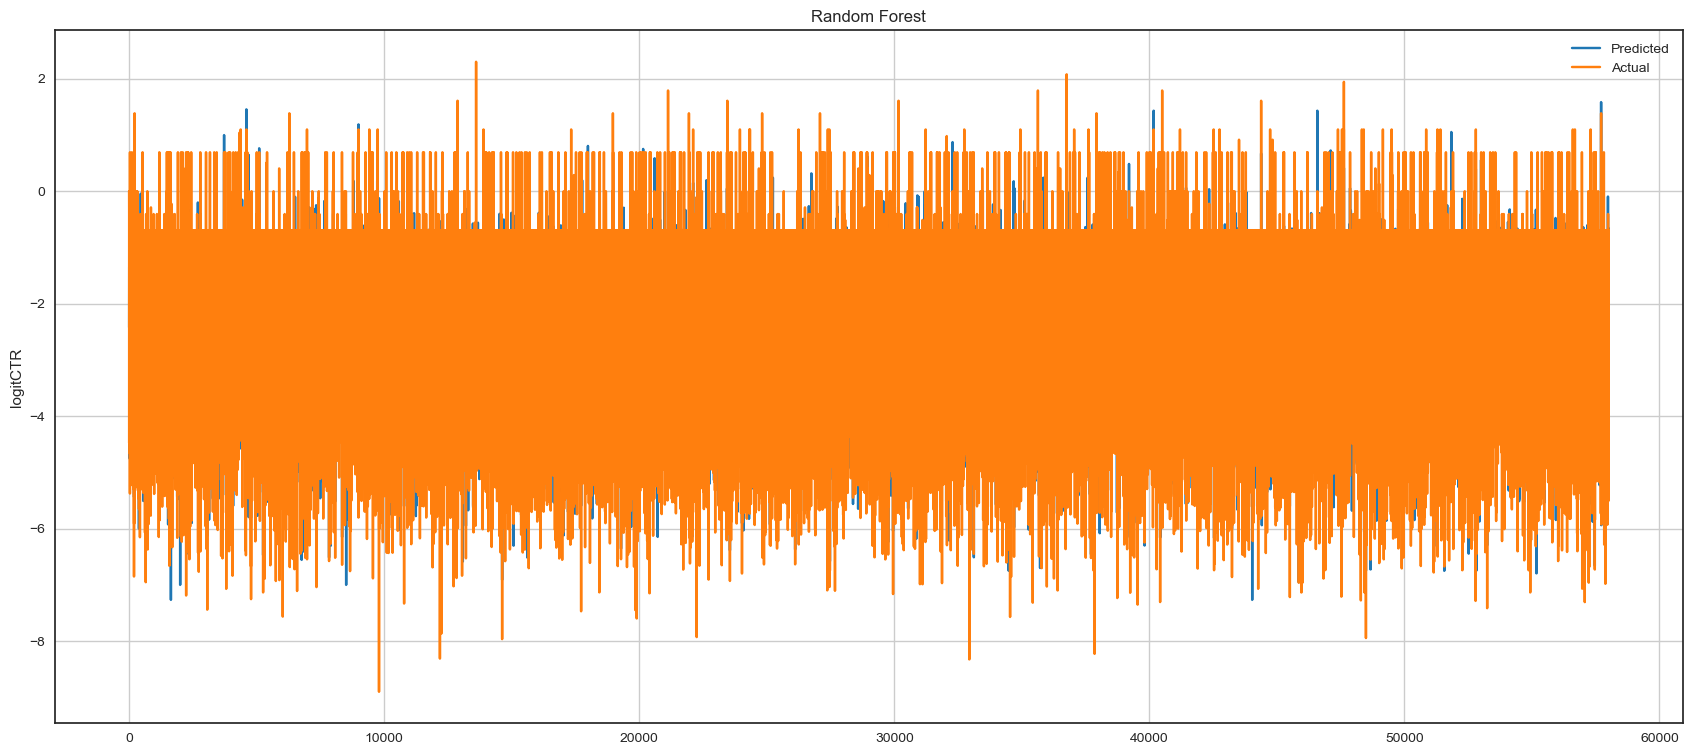

In [39]:
# plot fittes vs. actual
plt.figure(1)
plt.figure(figsize=(18,7))
plt.grid(True)
plt.title('Random Forest')
plt.plot(y_pred, label='Predicted')
plt.ylabel(dependent)
plt.legend()

plt.figure(2)
plt.grid(True)
plt.title('Random Forest')
plt.plot(y_test.values, label='Actual')
plt.ylabel(dependent)
plt.legend()

plt.show()

# 6. Random Forest: Gradient Boosting Trees

In [42]:
GradientBoostingRegressor()

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

### Explore Model behaviour

In [51]:
dependent = 'logitCTR'
X_data = dfLE[RFR_columns]
y_data = dfLE[dependent]

In [45]:
# Get detailed model scores and times
gbt2 = GradientBoostingRegressor(learning_rate=0.1, max_depth=7, n_estimators=100)
k_fold = KFold(n_splits=5)
cross_validate(gbt2, X_data, y_data, cv=k_fold, return_train_score=True)

{'fit_time': array([124.30310965, 127.53429461, 125.0711534 , 126.35522699,
        124.98914886]),
 'score_time': array([0.31701827, 0.29901695, 0.30401754, 0.29801726, 0.37902164]),
 'test_score': array([ 0.1227506 ,  0.15067939,  0.13102125,  0.18005958, -0.04935881]),
 'train_score': array([0.36924504, 0.37241143, 0.37277175, 0.36766687, 0.37603709])}

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2)

gbt = GradientBoostingRegressor(learning_rate=0.05, max_depth=12, n_estimators=200)
gbt.fit(X_train, y_train)
y_train_pred = gbt.predict(X_train)
y_valid_pred = gbt.predict(X_test)

In [56]:
print_model_scores(y_train, y_train_pred)
print_model_scores(y_test, y_valid_pred)
sorted(zip(gbt.feature_importances_, X_train.columns), reverse=True)

R^2: 0.6497 / Explained Var: 0.6497 / MSE: 0.6262 / RMSE 0.7914
R^2: 0.4778 / Explained Var: 0.4778 / MSE: 0.9258 / RMSE 0.9622


[(0.20845797958601037, 'product'),
 (0.18837445382507545, 'subProduct'),
 (0.10649503478387805, 'campaign'),
 (0.09835045313458955, 'publisherCategory'),
 (0.08817488611586734, 'avgCPC'),
 (0.07735058732933649, 'country'),
 (0.06376708069110597, 'Weekday'),
 (0.0451534313114443, 'networkType'),
 (0.03610149613329968, 'advertiserCategory'),
 (0.03284201764812619, 'advPackage'),
 (0.02706397159551946, 'channel'),
 (0.019447854568220027, 'advMaturity'),
 (0.00741905863455852, 'deviceType'),
 (0.0010016946429685378, 'os')]

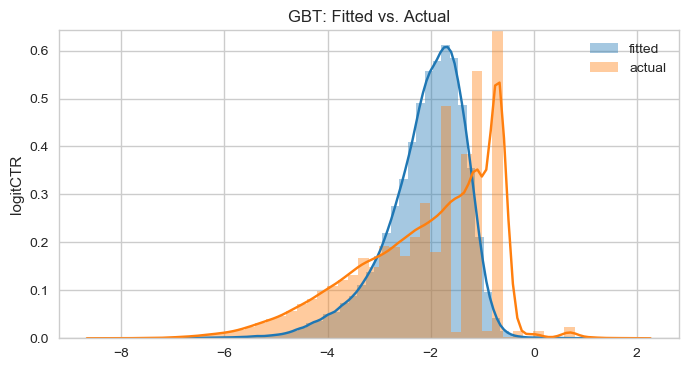

In [57]:
plt.title('GBT: Fitted vs. Actual')
sb.distplot(y_valid_pred,  label='fitted')
sb.distplot(y_test, label='actual')
plt.xlabel('')
plt.ylabel(dependent)
plt.legend()
plt.show()

# 7. Gradient Boosting Forest with XGBRegressor
http://xgboost.readthedocs.io/en/latest/model.html
---> xgboost can support custom loss functions

In [27]:
import xgboost
xgboost.XGBRegressor()

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

### Explore Model behaviour

In [28]:
dependent = 'logitCTR'
X_data = dfLE[RFR_columns]
y_data = dfLE[dependent]

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2)

xgb = xgboost.XGBRegressor(max_depth=12, learning_rate=0.1, n_estimators=500,
                           subsample=0.8, n_job=-1)
xgb_model = xgb.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

In [30]:
y_train_pred = xgb_model.predict(X_train)
print_model_scores(y_train, y_train_pred)

R^2: 0.8746 / Explained Var: 0.8746 / MSE: 0.2239 / RMSE 0.4732


In [31]:
print("Num of Features: {}".format(len(X_data.columns)))
print("y_train length: {}".format(len(y_train)))

Num of Features: 14
y_train length: 232034


In [32]:
print_model_scores(y_test, y_pred)
multioutput='uniform_average' #'variance_weighted'
print("Test Score using multioutput=%s" % multioutput)
print("--> XGB Score: {}".format(round(xgb_model.score(X_test, y_test),4)))
print("--> R^2 Score: {}".format(round(r2_score(y_test, y_pred, multioutput=multioutput), 4)))
sorted(zip(xgb_model.feature_importances_, X_data.columns), reverse=True)

R^2: 0.5605 / Explained Var: 0.5607 / MSE: 0.7825 / RMSE 0.8846
Test Score using multioutput=uniform_average
--> XGB Score: 0.5605
--> R^2 Score: 0.5605


[(0.17786849, 'Weekday'),
 (0.15161295, 'product'),
 (0.12786019, 'subProduct'),
 (0.10830689, 'campaign'),
 (0.10785299, 'publisherCategory'),
 (0.08492914, 'country'),
 (0.057835553, 'avgCPC'),
 (0.05700664, 'networkType'),
 (0.044128124, 'advertiserCategory'),
 (0.04241198, 'channel'),
 (0.017685091, 'advPackage'),
 (0.01078164, 'advMaturity'),
 (0.0101676695, 'deviceType'),
 (0.0015526477, 'os')]

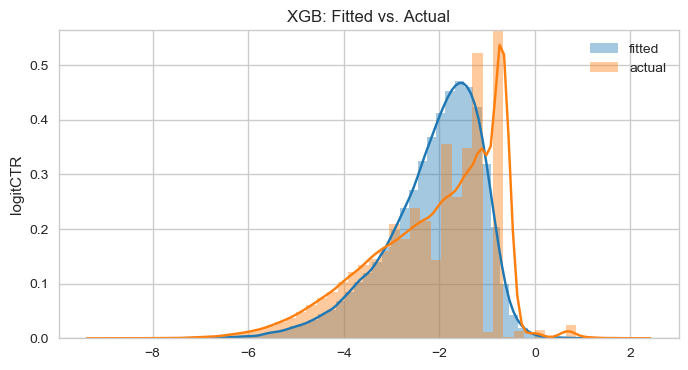

In [33]:
plt.title('XGB: Fitted vs. Actual')
sb.distplot(y_pred,  label='fitted')
sb.distplot(y_test, label='actual')
plt.xlabel('')
plt.ylabel(dependent)
plt.legend()
plt.show()

### XGB Randomized Grid Search

In [ ]:
dependent = 'logitCTR'
X_data = dfLE[RFR_columns]
y_data = dfLE[dependent]

# run randomized search
param = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 8, 12, 0],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.5, 0.75, 1.0]
}

rgr = xgboost.XGBRegressor()
gs = RandomizedSearchCV(rgr, param_distributions=param, n_iter=20, cv=5, return_train_score=True, n_jobs=-1)

gs_fit = gs.fit(X_data, y_data)
pd.DataFrame(gs_fit.cv_results_).sort_values('mean_test_score', ascending=False)[0:10]

In [ ]:
print("Feature importance::\n", sorted(zip(gs.best_estimator_.feature_importances_, X_data.columns), reverse=True))
print("Best params:\n", gs_fit.best_params_)

# Run Chosen Model on Test Data

In [53]:
# Label Encoder for categorical TEST Data
dfTest['avgCPC'] = dfTest['rate']
dfTest.head(10)

,sessionId,eDate,channel,country,os,networkType,deviceType,publisherCategory,advertiserCategory,product,subProduct,campaign,advPackage,advMaturity,rate,Date,Weekday,Dayname,avgCPC,CTR,Bid
0,9705699729732200,2017-12-17,4,6,1,2,0,37,5,244,72,371,18,2,0.010,2017-12-17,6,Sunday,0.010,0.046441,0.464408
1,12802690671750800,2017-12-17,4,28,0,0,0,36,6,375,457,225,65,7,0.008,2017-12-17,6,Sunday,0.008,0.021060,0.168478
2,21347409150256300,2017-12-17,4,24,1,1,0,37,38,517,252,125,14,2,0.020,2017-12-17,6,Sunday,0.020,0.030131,0.602628
3,23329125091887800,2017-12-17,0,47,0,0,0,43,27,1826,1040,260,30,8,0.022,2017-12-17,6,Sunday,0.022,0.004317,0.094979
4,28266843791174100,2017-12-17,4,14,0,3,0,40,28,627,763,236,65,5,0.025,2017-12-17,6,Sunday,0.025,0.013840,0.346005
5,38885354599292096,2017-12-17,4,6,1,3,0,37,5,276,46,371,18,2,0.010,2017-12-17,6,Sunday,0.010,0.064314,0.643141
6,46350075538682200,2017-12-17,1,27,1,3,0,37,31,728,1133,130,66,1,0.020,2017-12-17,6,Sunday,0.020,0.210138,4.202757
7,49092479590685296,2017-12-17,0,47,0,0,0,43,27,1826,1040,260,30,8,0.019,2017-12-17,6,Sunday,0.019,0.003946,0.074981
8,66271671661355000,2017-12-17,0,6,0,0,0,17,6,1570,745,170,65,7,0.025,2017-12-17,6,Sunday,0.025,0.020447,0.511164
9,67481259350022496,2017-12-17,4,56,1,1,0,37,26,531,72,373,10,0,0.025,2017-12-17,6,Sunday,0.025,0.209278,5.231956


In [42]:
# create final TEST prediction
pred_logit = xgb_model.predict(dfTest[RFR_columns])

In [51]:
pred_ctr = [logit2prob(item) for item in pred_logit]

In [54]:
# compue the Bid
dfTest['CTR'] = pd.Series(pred_ctr)
dfTest['Bid'] = 1000 * dfTest['CTR'] * dfTest['rate']

In [55]:
# save CSV file
dfTest.to_csv(mainDir + '/bids.csv', columns=['sessionId', 'CTR', 'Bid'], index=False)

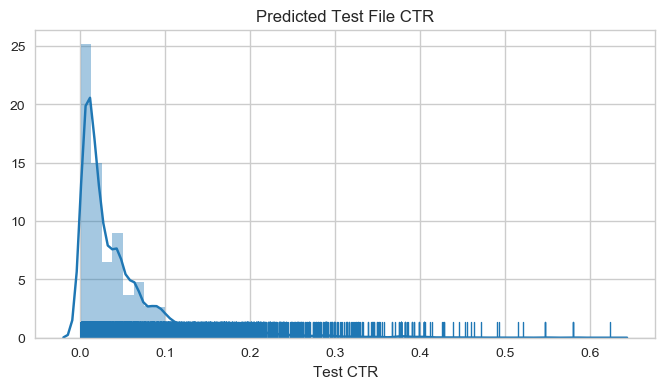

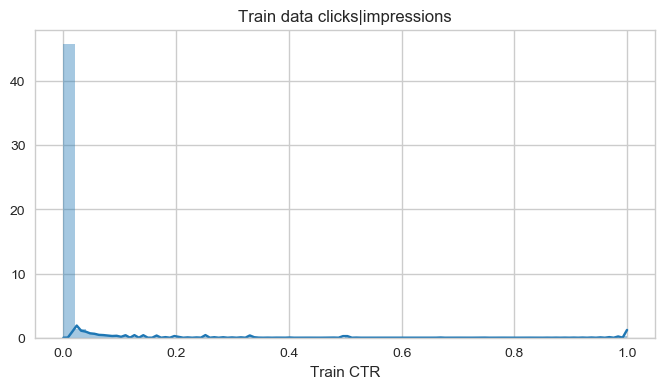

In [62]:
plt.title('Predicted Test File CTR')
sb.distplot(dfTest['CTR'], rug=True)
plt.xlabel('Test CTR') 
plt.show()

plt.title('Train data clicks|impressions')
sb.distplot(trainData['CTR'])
plt.xlabel('Train CTR') 
plt.show()

# 8. SVM: Support Vector Regression
## Runs extremely slow!

In [63]:
from sklearn.svm import SVR
SVR()

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [ ]:
dependent = 'logitCTR'
X_data = dfLE[RFR_columns]
y_data = dfLE[dependent]

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2)

# epsilon = margin width; C = penalty distance from the margin
kernel='rbf' # 'linear'
svm = SVR(C=1.0, epsilon=0.2, kernel=kernel)
svm_model = svm.fit(X_train, y_train)

In [ ]:
svm_model.coef_
sorted(zip(svm_model.coef_[0], X_data.columns), reverse=True)

In [ ]:
svm_model.score(X_train, y_train)

In [ ]:
sorted_coef = sorted(zip(svm_model.coef_[0], X_dtrain.columns), reverse=True)
coef = pd.Series(svm_model.coef_[0], X_train.columns).sort_values()
coef.plot(kind='bar', title='SVR Coefficients')

In [ ]:
y_pred = svm.predict(X_test)

In [ ]:
plt.title('Support Vector Regression')
sb.distplot(y_pred,  label='fitted')
sb.distplot(y_test, label='actual')
plt.xlabel('')
plt.ylabel(dependent)
plt.legend()
plt.show()

In [ ]:
svm_model.score(X_test, y_test)

In [ ]:
print_model_scores(y_test, y_pred)

# 9. GLM: Binomial Response
## TODO

In [ ]:
import statsmodels.api as sm